In [1]:
import keras
import tensorflow as tf
import keras.layers as layers
import keras.activations as activations
import numpy as np

import pylab as pl
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal 
from scipy.io import wavfile

import sounddevice as sd

2022-04-19 14:13:03.459152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 14:13:03.459190: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Mise en place des données tests

/tmp/ipykernel_2893/2850441478.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  rate, sls = wavfile.read('Sls.wav')


172.8


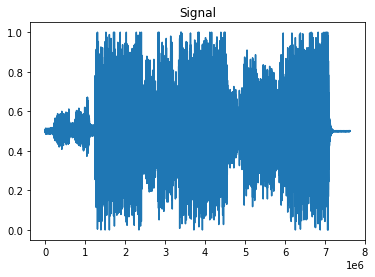

In [2]:
rate, sls = wavfile.read('Sls.wav')
sls = sls/np.max(sls)

N = len(sls)
print(N/rate)

time = np.arange(N)/rate

plt.plot(sls)
plt.title('Signal')
plt.show()

sd.play(sls/np.max(sls),rate)

ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred


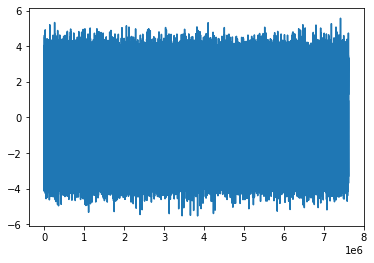

In [3]:
Ns = N
sigma_carre = 1.2

#compute gaussian signal
Samples = np.power(1.2,0.5)*np.random.randn(Ns)
abs = np.arange(Ns)
pl.plot(abs,Samples)
pl.show()

ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred
ALSA lib pcm.c:8306:(snd_pcm_recover) underrun occurred


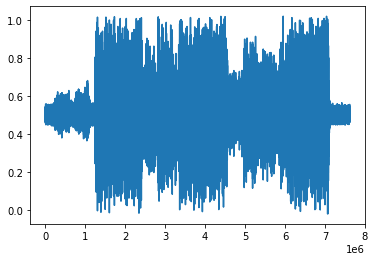

In [4]:
slsn = sls + Samples/90

pl.plot(slsn)

pl.show()

#sd.play(slsn[3200000:3200000+3200000]/np.max(sls),rate)

In [14]:
def make_extrait(x,fs):
    data = np.zeros((1,fs*2))
    i=0
    data = [x[i:i+fs*2]]
    i+=fs
    while(i+fs*2<len(x)):

        data = np.concatenate((data,[x[i:i+fs*2]]),0)
        i += fs
    
    return data






In [39]:
print(np.shape(sls))

ex_sls = make_extrait(sls,rate)
ex_slsn = make_extrait(slsn,rate)

print(np.shape(ex_sls))
print(np.shape(ex_slsn)) 

t, f, stft_c = scipy.signal.stft(ex_sls[0],rate, 'hann',512,128)
t, f, stft_n = scipy.signal.stft(ex_sls[0],rate, 'hann',512,128)
stft_c = [stft_c]
stft_n = [stft_n]
for i in range(1,np.shape(ex_sls)[0]):
    t, f, a = scipy.signal.stft(ex_sls[i],rate, 'hann',512,128)
    t, f, b = scipy.signal.stft(ex_sls[i],rate, 'hann',512,128)

    stft_c = np.concatenate((stft_c,[a]),axis=0)
    stft_n = np.concatenate((stft_n,[a]),axis=0)


print(np.shape(stft_c))
print(np.shape(stft_n)) 





(7620480,)
(171, 88200)
(171, 88200)
(171, 257, 231)
(171, 257, 231)


Nous avons nos deux signaux de base, l'un bruité slsn, et l'autre propre sls.

# 2. Écriture des loss function

In [42]:
a = tf.constant([1,2])
b = tf.constant([3,2])

tf.tensordot(a,b,1).numpy()

7

In [21]:
def L_wav(y_true,y_pred):

    return -tf.divide(tf.tensordot(y_pred,y_true,1),tf.multiply(tf.norm(y_pred),tf.norm(y_true)))

def L_spec(y_true,y_pred):

    return tf.pow(tf.norm(tf.pow(tf.norm(y_true),0.3)-tf.pow(tf.norm(y_pred),0.3)),2)


# 3. Depthwise-separable convolution

In [63]:
class DepthwiseSeparableConv1d(tf.keras.Model):
    def __init__(self, in_channels, out_channels, kernel_size, stride):


        super().__init__()

        shape = ([None, in_channels])
        self.kernel = kernel_size
      
        self.conv1d_1 = layers.Conv1D(out_channels, kernel_size, input_shape =(None, in_channels), padding='same' ,groups = 1, strides = stride)
        
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.relu1 = layers.Activation(activations.relu)

        self.conv1d_2 = tf.keras.layers.Conv1D(out_channels , 1)

        self.norm2 = tf.keras.layers.BatchNormalization()
        self.relu2 = layers.Activation(activations.relu)


    def call (self, x):

        x = self.conv1d_1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        print(np.shape(x))

        #pad = np.zeros((np.shape(x)[0],self.kernel//2,np.shape(x)[2]))
        #pad_x = np.concatenate((pad,x.numpy(),pad),axis=1)
        y = self.conv1d_2(x)
        y = self.norm2(y)
        y = self.relu2(y)

        return y



In [64]:
model = DepthwiseSeparableConv1d(257,257,5,1)
x = tf.random.uniform(shape= [1, 231, 257])
y = model(x)
print(np.shape(y))

(1, 231, 257)
(1, 231, 257)


In [65]:
model = DepthwiseSeparableConv1d(257,257,5,1)

x = tf.math.abs(tf.constant(stft_n))
y = tf.math.abs(tf.constant(stft_c))
print(np.shape(x))
x=tf.transpose(x, perm=[0,2,1])
y=tf.transpose(y, perm=[0,2,1])
print(np.shape(x))
model.compile(loss=L_spec,optimizer='adam')
model.fit(x,y, verbose=2, epochs=100,batch_size=20,shuffle=True)

(171, 257, 231)
(171, 231, 257)
Epoch 1/100
(None, 231, 257)
(None, 231, 257)
9/9 - 1s - loss: 12.9263 - 1s/epoch - 152ms/step
Epoch 2/100
9/9 - 1s - loss: 5.6492 - 599ms/epoch - 67ms/step
Epoch 3/100
9/9 - 1s - loss: 2.6944 - 620ms/epoch - 69ms/step
Epoch 4/100
9/9 - 1s - loss: 1.7007 - 620ms/epoch - 69ms/step
Epoch 5/100
9/9 - 1s - loss: 1.1188 - 606ms/epoch - 67ms/step
Epoch 6/100
9/9 - 1s - loss: 0.7254 - 605ms/epoch - 67ms/step
Epoch 7/100
9/9 - 1s - loss: 0.4083 - 604ms/epoch - 67ms/step
Epoch 8/100
9/9 - 1s - loss: 0.1746 - 592ms/epoch - 66ms/step
Epoch 9/100
9/9 - 1s - loss: 0.0614 - 584ms/epoch - 65ms/step
Epoch 10/100
9/9 - 1s - loss: 0.0107 - 603ms/epoch - 67ms/step
Epoch 11/100
9/9 - 1s - loss: 0.0087 - 575ms/epoch - 64ms/step
Epoch 12/100
9/9 - 1s - loss: 0.0086 - 572ms/epoch - 64ms/step
Epoch 13/100
9/9 - 1s - loss: 0.0044 - 568ms/epoch - 63ms/step
Epoch 14/100
9/9 - 1s - loss: 0.0059 - 569ms/epoch - 63ms/step
Epoch 15/100
9/9 - 1s - loss: 0.0045 - 562ms/epoch - 62ms/step

In [48]:
t, f, a = scipy.signal.stft(slsn,rate, 'hann',512,128)
t, f, b = scipy.signal.stft(sls,rate, 'hann',512,128)
at = tf.math.abs(tf.constant([a]))


phase = np.angle(sls)
ad = model(at).numpy() * np.exp(phase*1j)

xrec = scipy.signal.istft(ad,rate, 'hann',512,128)

pl.plot(xrec)
pl.show()

ValueError: Exception encountered when calling layer "depthwise_separable_conv1d_16" (type DepthwiseSeparableConv1d).

Input 0 of layer "conv1d_32" is incompatible with the layer: expected axis -1 of input shape to have value 231, but received input with shape (1, 257, 19846)

Call arguments received:
  • x=tf.Tensor(shape=(1, 257, 19846), dtype=float32)

In [51]:
test = keras.Sequential()
test.add(layers.Conv1D(231,5,1,'same',groups=1))

x = tf.random.uniform(shape= [1, 231, 257])
y = test(x)
y

<tf.Tensor: shape=(1, 231, 1000), dtype=float32, numpy=
array([[[-0.1129044 ,  0.24058071,  0.35043016, ..., -0.32193992,
          0.12692675, -0.24686976],
        [ 0.10636537, -0.09141742,  0.5046648 , ..., -0.25187305,
         -0.18411109,  0.1294954 ],
        [ 0.33206356, -0.03364752,  0.3290662 , ..., -0.50172156,
         -0.52960974, -0.01551561],
        ...,
        [-0.11772887,  0.27366632,  0.6082838 , ..., -0.53114223,
         -0.6154522 , -0.27121508],
        [-0.02738854, -0.44436035,  0.65297437, ..., -0.5382412 ,
         -0.29601642, -0.04827364],
        [ 0.26115444, -0.13905348,  0.40590957, ..., -0.3877795 ,
         -0.69398636,  0.2898773 ]]], dtype=float32)>